In [1]:
import pyfits
import math as m
import numpy as np
import scipy as sp
from scipy import stats
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import cProfile
import pstats
import StringIO

In [2]:
#set up for probability distributions
#all p(z) share these bins from Sheldon, et al.
zbins = pyfits.open("http://data.sdss3.org/sas/dr8/groups/boss/photoObj/photoz-weight/zbins-12.fits")

#reformat bins
zlos = [zbins[1].data[i][0] for i in range(0,len(zbins[1].data))]
zhis = [zbins[1].data[i][1] for i in range(0,len(zbins[1].data))]
nbins = len(zbins[1].data)

#use centers of bins for plotting
zmids = [(zbins[1].data[i][0]+zbins[1].data[i][1])/2. for i in range(0,nbins)]
zavg = sum(zmids)/nbins

#useful for plotting
zdifs = [zbins[1].data[i][1]-zbins[1].data[i][0] for i in range(0,nbins)]
zdif = sum(zdifs)/nbins

In [3]:
seed_ngals = 1000
#define flat distribution for N(z)
avg_prob = 1./nbins/zdif
#avg_prob = [1./nbins/zdifs[k] for k in range(0,nbins)]
flat = seed_ngals*avg_prob#[[n*avg_prob[k] for k in range(0,nbins)] for n in ngals]
logflat = m.log(flat)#[[m.log(f[k]) for k in range(0,nbins)] for f in flat]
onetrueflatNz = np.array([flat]*nbins)#[np.array([f[k]/zdifs[k] for k in range(0,nbins)]) for f in flat]
logonetrueflatNz = np.array([logflat]*nbins)#[[m.log(f) for f in fn] for fn in flatNz]#[np.array([fl]*nbins) for fl in logflat]
#onetrueflatNz = seed_ngals*np.array(avg_prob)
#logonetrueflatNz = [m.log(f) for f in onetrueflatNz]

In [4]:
import math as m
import numpy as np
import scipy as sp
from scipy import stats
import sys

class mvn(object):
    def __init__(self,mean,cov):
        self.dims = len(mean)
        self.mean = mean
        self.cov = cov
        #assert np.all(sp.linalg.eigh(self.cov)[0] >= 0.)
        self.icov = np.linalg.pinv(self.cov)
        (self.logdetsign,self.logdet) =  np.linalg.slogdet(self.cov)
        #assert self.logdetsign >= 0.
    def logmvn(self):
        def logmvnImpl(x):
            a = self.logdet
            b = self.dims*np.log(2*m.pi)
            c = np.dot(x-self.mean, np.dot(self.icov, x-self.mean))
            return -0.5*(a+b+c)
        return logmvnImpl
        #return lambda x: 0.5*(np.log(self.ilogdet)-len(x)*np.log(2*m.pi)-np.dot((x-self.mean),np.dot(self.icov,(x-self.mean))))
    def logpdf(self,x):
        testprob = self.logmvn()(x)
        a = np.isnan(testprob) == True
        b = np.isinf(testprob) == True
        c = testprob >= 0.#sys.float_info.max
        d = testprob <= -1.*sys.float_info.max#epsilon
        #e = testprob > m.exp(self.logmvn()(self.mean))
        #assert a and b and c and d# and e
        if a or b or c or d:# or e:
            testprob = -1*sys.float_info.max#epsilon#-1.e+308#m.exp(m.log(sys.float_info.max))#sys.float_info.max+1.e+308#sys.float_info.epsilon#m.log(sys.float_info.epsilon)
        return testprob
    def sample_dumb(self,N):
        outsamp = [sp.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov) for n in range(0,N)]
        sampprobs = [self.logpdf(s) for s in outsamp]
        #assert np.any(np.isnan(sampprobs)) == False
        return outsamp
    def sample_legit(self,N):
        #rando = sp.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov)
        #sigma = 100.#[np.median(self.cov[i]) for i in range(0,dims)]
        outsamp = [self.mean+np.random.randn(self.dims) for n in range(0,N)]#[rando+np.random.randn(dims) for n in range(0,N)]
        sampprobs = [self.logpdf(s) for s in outsamp]
        #assert np.any(np.isnan(sampprobs)) == False
        return outsamp
    def sample_test(self,N):
        rando = sp.stats.multivariate_normal.rvs(mean=self.mean,cov=self.cov)
        #sigma = 100.#[np.median(self.cov[i]) for i in range(0,dims)]
        outsamp = [rando+np.random.randn(self.dims) for n in range(0,N)]#[rando+np.random.randn(dims) for n in range(0,N)]
        sampprobs = [self.logpdf(s) for s in outsamp]
        #assert np.any(np.isnan(sampprobs)) == False
        return rando,outsamp    

In [5]:
ndim = 35
logmu = logonetrueflatNz[:ndim]
q=1.#0.5
e=0.1
covmat = [[q*m.exp(-0.5*e*(i-j)**2.) for j in range(0,ndim)] for i in range(0,ndim)]
#priordist = sp.stats.multivariate_normal(mean=logmu,cov=covmat)
priordist = mvn(logmu,covmat)

nwalkers = 80
iguess_dumb = priordist.sample_dumb(nwalkers)
iguess_legit = priordist.sample_legit(nwalkers)
rando_test,iguess_test = priordist.sample_test(nwalkers)
iguess_both = [iguess_dumb,iguess_legit,iguess_test]
means_both = [logmu,logmu,rando_test]
ntests = len(iguess_both)
setups_both = ['Prior Samples','Gaussian Ball Around Mean','Gaussian Ball Around Prior Sample']

outiters,outfracs,outtimes = [],[],[]

/Users/aimalz/anaconda/lib/python2.7/site-packages/scipy/stats/_multivariate.py:406: RuntimeWarning: covariance is not positive-semidefinite.
  out = np.random.multivariate_normal(mean, cov, size)


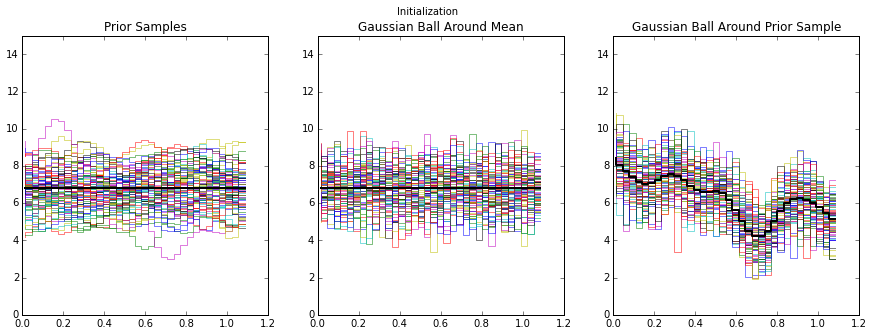

In [7]:
plt.figure(figsize=(5*ntests,5))
plt.suptitle('Initialization')
for n in range(0,ntests):
    plt.subplot(1,ntests,n+1)
    plt.ylim(0,15)
    plt.title(setups_both[n])
    for i in iguess_both[n]:
        plt.step(zmids[:ndim],i,alpha=0.5)
    plt.step(zmids[:ndim],means_both[n],color='k',linewidth=2)
plt.savefig('initialization-compare.png',dpi=100)
plt.show()
plt.close()

In [8]:
priordist = mvn(logmu,covmat)
sampler = emcee.EnsembleSampler(nwalkers, ndim, priordist.logpdf)
niters = range(3,6)

#pos0_all
def sampling(n,t):
    sampler.reset()
    fracs,times,probs,chains = [],[],[],[]
    pos0 = iguess_both[n]
    pos0, prob0, state0 = sampler.run_mcmc(pos0, 10**t)
    frac = sampler.acceptance_fraction
    fracs.append(frac)
    time = sampler.get_autocorr_time()
    times.append(time)
#    for walk in sampler.chain:#nwalkers
#        chain = np.transpose(walk)
#        chains.append(chain)
#        prob = []#np.zeroes(nwalkers)#[]
#        for chain in walk:#nburns
#            newprob = priordist.logpdf(chain)
            #assert np.isnan(newprob)==False
#            prob.append(newprob)
#        probs.append(prob)
    return fracs,times,probs,chains
    
def samplings():
    for t in niters:
        fracs,times,probs,chains = [],[],[],[]
        for n in range(0,ntests):
            frac,time,prob,chain = sampling(n,t)
            fracs.append(frac)
            times.append(time)
            #probs.append(prob)
            #chains.append(chain)
        outfracs.append(fracs)
        outtimes.append(times)
        print(str(10**t))
    return fracs,times,probs,chains

In [9]:
pr = cProfile.Profile()
pr.enable()
fracs_all,times_all,probs_all,chains_all = samplings()
pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

1000
10000
100000
         194810874 function calls in 988.431 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  2664063  290.128    0.000  290.128    0.000 {method 'reduce' of 'numpy.ufunc' objects}
 26640720  210.417    0.000  478.712    0.000 <ipython-input-4-0757689ba855>:24(logpdf)
 26640720  171.565    0.000  259.741    0.000 <ipython-input-4-0757689ba855>:17(logmvnImpl)
 53281440   88.175    0.000   88.175    0.000 {numpy.core._dotblas.dot}
   666000   41.701    0.000  649.277    0.001 /Users/aimalz/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:292(_propose_stretch)
   666009   36.520    0.000  590.083    0.001 /Users/aimalz/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:340(_get_lnprob)
 26640720   27.213    0.000  505.925    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/emcee/ensemble.py:503(__call__)
   333009   24.743    0.000  698.409    0.002 /Users/aimalz/anaconda/lib/python2.7/site